In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import numpy as np 
from pytomography.io.SPECT import simind
import torch
from network import UNetCustom

In [3]:
def plot_logs(experiment_code_list):
    n_channels_list = [[int(i) for i in exp_code.split('_')[1].split('x')] for exp_code in experiment_code_list]
    save_dir = '/home/sahamed/Projects/pytomography/scatter-estimation-deep-image-prior/network_ablation_experiments'
    logs_fpath_list = [os.path.join(save_dir, 'logs', f'{exp_code}', 'logs.csv') for exp_code in experiment_code_list]

    loss_list = [pd.read_csv(path)['Loss'].tolist() for path in logs_fpath_list] 
    epoch_list = [np.arange(len(ll)) + 1 for ll in loss_list]
    min_loss_list = [np.min(ll) for ll in loss_list]

    fig, ax = plt.subplots(1,2, figsize=(10,5))
    fig.patch.set_facecolor('white')
    fig.patch.set_alpha(1)
    
    for i in range(len(loss_list)):
        ax[0].plot(epoch_list[i], loss_list[i], label=n_channels_list[i])
    
    ax[0].legend()
    ax[1].plot(experiment_code_list, min_loss_list, '-o')
    ax[1].set_xticklabels(n_channels_list, rotation=45, ha='right')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('MSELoss')
    ax[1].set_xlabel('Network ablations')
    ax[1].set_ylabel('Minimum MSELoss')
    plt.show()

/tmp/ipykernel_387/1623158067.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(n_channels_list, rotation=45, ha='right')


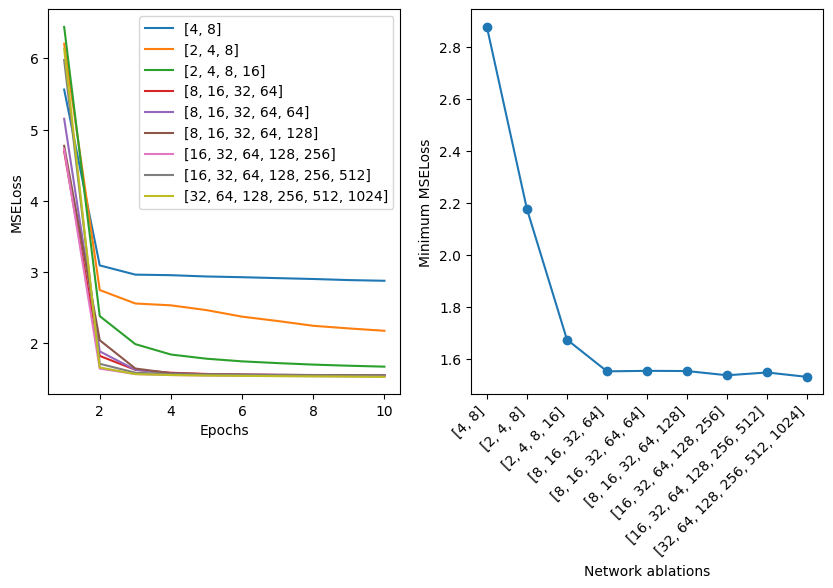

In [4]:
path = '/home/sahamed/Projects/pytomography/scatter-estimation-deep-image-prior/network_ablation_experiments/models'
experiment_code_list = sorted(os.listdir(path), key=len)
plot_logs(experiment_code_list)

In [5]:
def get_noiseless_and_noisy_scatter_images():
    path = '/home/sahamed/Projects/pytomography/scatter-estimation-deep-image-prior/simind_tutorial'
    organs = ['bkg', 'liver', 'l_lung', 'r_lung', 'l_kidney', 'r_kidney','salivary', 'bladder']
    activities = [2500, 450, 7, 7, 100, 100, 20, 90] # MBq
    headerfiles = [os.path.join(path, 'multi_projections', organ, 'photopeak.h00') for organ in organs]
    dT = 15 # seconds per projection
    headerfiles_lower = [os.path.join(path, 'multi_projections', organ, 'lowerscatter.h00') for organ in organs]
    headerfiles_upper = [os.path.join(path, 'multi_projections', organ, 'upperscatter.h00') for organ in organs]
    projections = simind.get_projections([headerfiles, headerfiles_lower, headerfiles_upper], weights=activities)
    projections_realization = torch.poisson(projections * dT)
    ww_peak = simind.get_energy_window_width(headerfiles[0])
    ww_lower = simind.get_energy_window_width(headerfiles_lower[0])
    ww_upper = simind.get_energy_window_width(headerfiles_upper[0])
    lower_scatter = projections_realization[1].unsqueeze(0)
    upper_scatter = projections_realization[2].unsqueeze(0)
    scatter = (lower_scatter/ww_lower+upper_scatter/ww_upper)*ww_peak/2
    lower_scatter_noiseless = projections[1].unsqueeze(0) * dT
    upper_scatter_noiseless = projections[2].unsqueeze(0) * dT
    scatter_noiseless = (lower_scatter_noiseless/ww_lower+upper_scatter_noiseless/ww_upper)*ww_peak/2
    return scatter_noiseless, scatter

In [6]:
def plot_images(experiment_code_list, projection_num):
    n_channels_list = [[int(i) for i in exp_code.split('_')[1].split('x')] for exp_code in experiment_code_list]
    save_dir = '/home/sahamed/Projects/pytomography/scatter-estimation-deep-image-prior/network_ablation_experiments'
    preds_fpath_list = [os.path.join(save_dir, 'predictions', f'{exp_code}', 'pred.pt') for exp_code in experiment_code_list]
    scatter_noiseless, scatter = get_noiseless_and_noisy_scatter_images()
    
    fig, ax = plt.subplots(1, 2+len(experiment_code_list), figsize=(5*(2 + len(experiment_code_list)), 15))
    fig.patch.set_facecolor('white')
    fig.patch.set_alpha(1)
    mse_list = []
    ax[0].imshow(np.rot90(scatter_noiseless[0, projection_num].cpu()), cmap='magma', vmax=16)
    ax[1].imshow(np.rot90(scatter[0, projection_num].cpu()), cmap='magma', vmax=16)
    ax[0].set_title('Noiseless scatter', fontsize=16)
    ax[1].set_title('Noisy scatter', fontsize=16)
    for i in range(2, 2+len(experiment_code_list)):
        scatter_pred = torch.load(preds_fpath_list[i-2])
        sq_diff = (scatter_pred - scatter_noiseless)**2
        mse = torch.mean(sq_diff)
        mse_list.append(mse.item())
        ax[i].imshow(np.rot90(scatter_pred[0, projection_num].cpu().detach()), cmap='magma', vmax=16)
        ax[i].set_title(n_channels_list[i-2], fontsize=20)

    for i in range(2+len(experiment_code_list)):
        ax[i].axis('off')
    plt.show()
    return mse_list


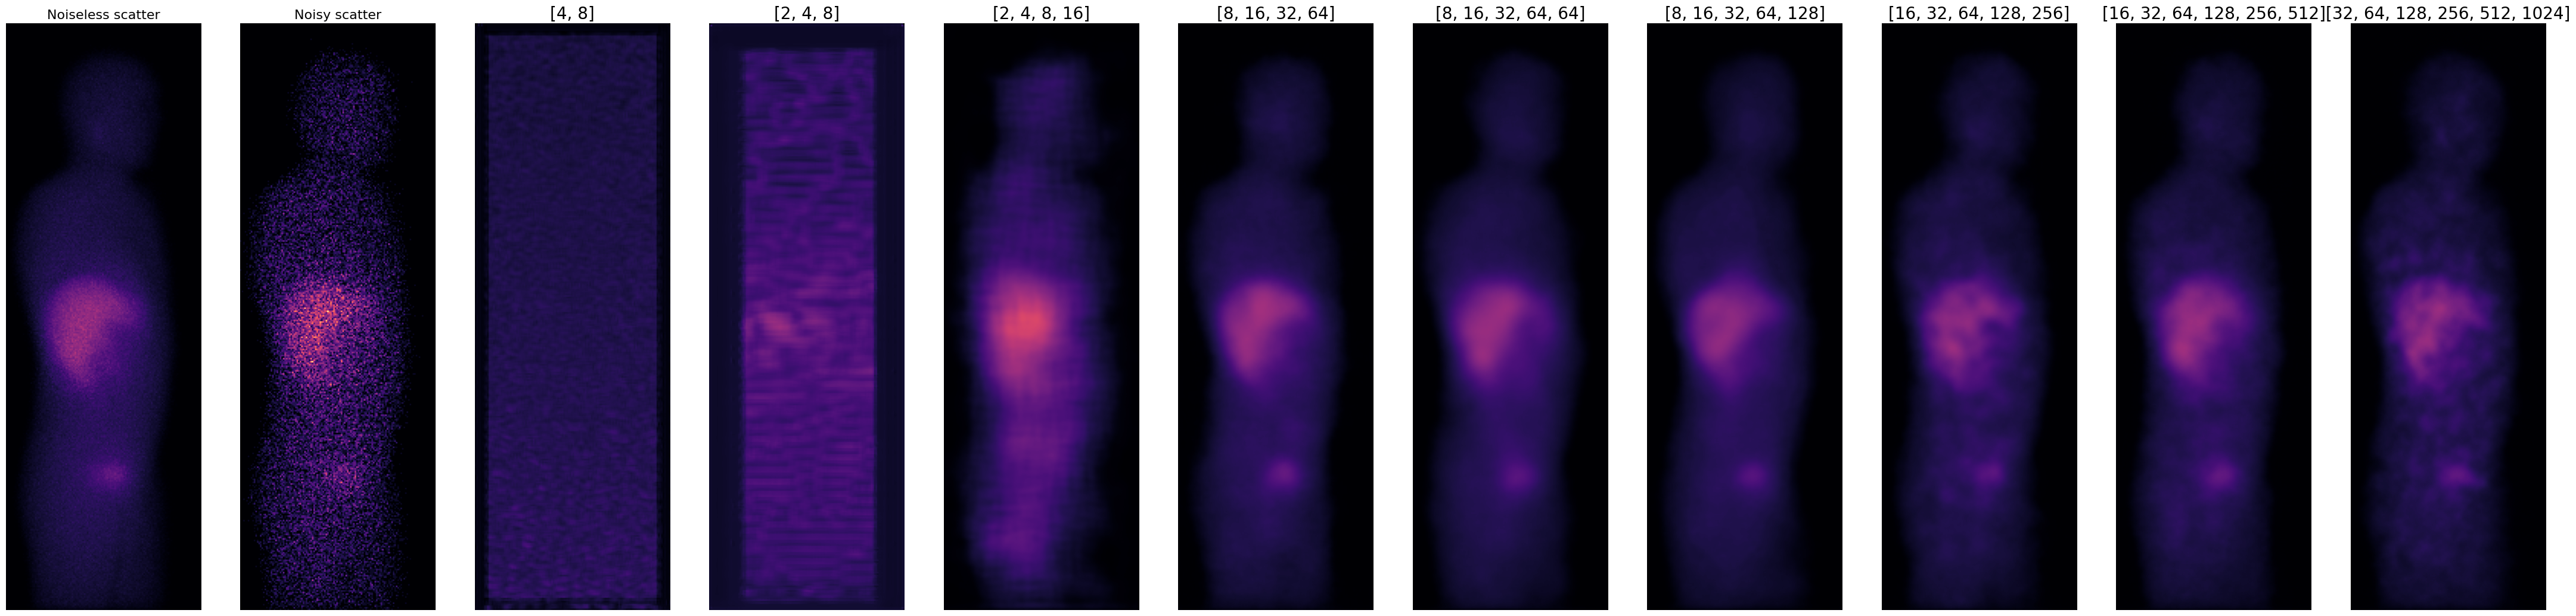

/tmp/ipykernel_387/411116938.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(n_channels_list, rotation=45, ha='right')


Text(0.5, 1.0, 'Scatter predicted vs. Scatter noiseless')

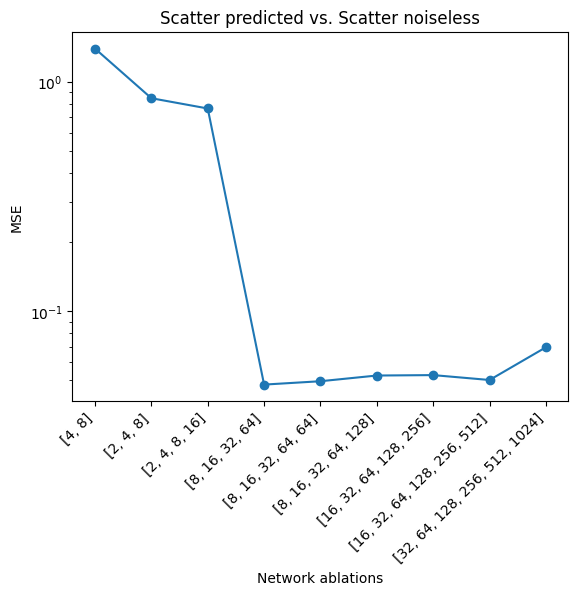

In [8]:
mse_list = plot_images(experiment_code_list, 20)
n_channels_list = [[int(i) for i in exp_code.split('_')[1].split('x')] for exp_code in experiment_code_list]
fig, ax = plt.subplots()
ax.plot(experiment_code_list, mse_list, '-o')
ax.set_xticklabels(n_channels_list, rotation=45, ha='right')
ax.set_yscale('log')
ax.set_xlabel('Network ablations')
ax.set_ylabel('MSE')
ax.set_title('Scatter predicted vs. Scatter noiseless')

In [3]:
import torch 
import os 
import matplotlib.pyplot as plt 

In [20]:
path = '/home/sahamed/Projects/pytomography/scatter-estimation-deep-image-prior/ablation_experiments'
dT = 15
exp_code = 'unet_8x16x32x64'
dir = os.path.join(path, f'dT{dT}_NoiseInput', 'reconstructions', f'{exp_code}')
recon_noiseless_fpath = os.path.join(dir, 'recon_osem_scatter_noiseless.pt')
recon_noisy_fpath = os.path.join(dir, 'recon_osem_scatter_noisy.pt')
recon_pred_fpath = os.path.join(dir, 'recon_osem_scatter_pred.pt')

recon_noiseless = torch.load(recon_noiseless_fpath)
recon_noisy = torch.load(recon_noisy_fpath)
recon_pred = torch.load(recon_pred_fpath)

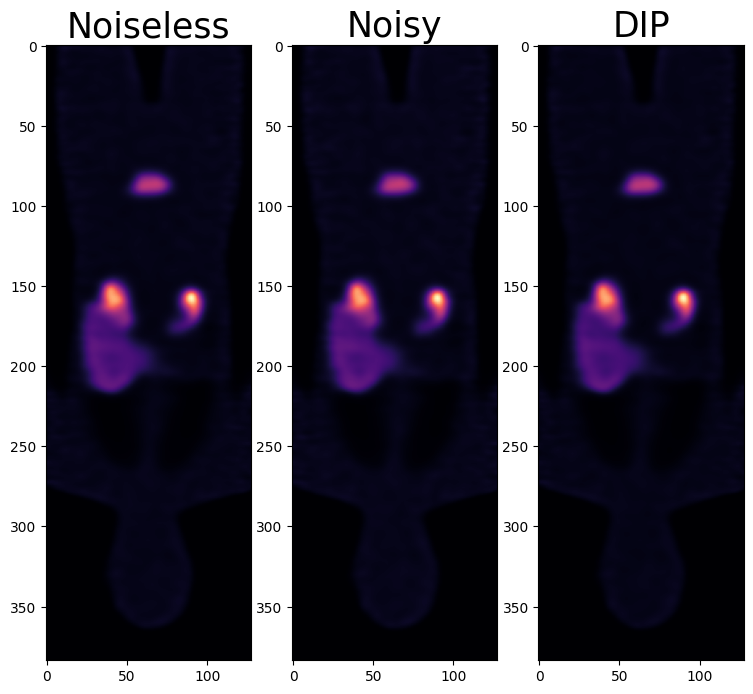

In [24]:
fig, ax = plt.subplots(1,3, figsize=(9, 8))
ax[0].imshow(recon_noiseless[0].cpu()[:,70].T, cmap='magma')
ax[0].set_title('Noiseless', fontsize=25)
ax[1].imshow(recon_noisy[0].cpu()[:,70].T, cmap='magma')
ax[1].set_title('Noisy', fontsize=25)
ax[2].imshow(recon_pred[0].cpu()[:,70].T, cmap='magma')
ax[2].set_title('DIP', fontsize=25)
plt.show()


In [25]:
path = '/home/sahamed/Projects/pytomography/scatter-estimation-deep-image-prior/simind_tutorial/phantom_organs/l_lung_act_av.bin'
with open(path, mode='rb') as file: # b is important -> binary
    fileContent = file.read()

In [1]:
import numpy as np 
def read_bin_file(file_path, dtype=np.uint8):
    with open(file_path, 'rb') as f:
        data = np.fromfile(f, dtype=dtype)
    return data

In [15]:
import os 
from skimage.transform import resize
path = '/home/sahamed/Projects/pytomography/scatter-estimation-deep-image-prior/simind_tutorial'
organs = ['bkg', 'liver', 'l_lung', 'r_lung', 'l_kidney', 'r_kidney','salivary', 'bladder']
GTfiles = [os.path.join(path, 'phantom_organs', f'{organ}_act_av.bin') for organ in organs]
GT_shape = (768,512,512)
GT_spacing = (0.15,0.075,0.075) #cm
object_shape = (128, 128, 384)
object_dr = (0.3, 0.3, 0.3)
mask = np.zeros(object_shape)
mask_idx_dict = {}
mask_vol_dict = {}
organ_vol_dict = {}
for i, GT_path in enumerate(GTfiles):
    # Open GT file
    GTi = np.fromfile(GT_path, dtype=np.float32)
    # Reshape to 3D dimensions
    GTi = GTi.reshape((768,512,512))
    # Tranpose x/z axis to fit with pytomography standards
    GTi = np.transpose(GTi, (2,1,0))
    # Look for values >0 that specify the mask
    GTi = (GTi>0).astype(np.float32)
    # Find the volume of the organ (in mL)
    organ_vol_dict[organs[i]] = GTi.sum() * np.prod(GT_spacing)
    # Resize the mask to be the same shape as the reconstructed object
    GTi = resize(GTi, object_shape, anti_aliasing=True)
    # Take only voxels that are 50% inside the organ/region
    GTi = GTi>=0.5
    # Find the volume of the organ mask (in mL)
    mask_vol_dict[organs[i]] = GTi.sum() * np.prod(object_dr)
    # Update the mask
    mask[GTi] = i+1
    mask_idx_dict[organs[i]] = i+1

In [21]:
for i, GT_path in enumerate(GTfiles):
    GTi = np.fromfile(GT_path, dtype=np.float32)
    print(np.unique(GTi, return_counts=True))

(array([0.       , 0.1687915], dtype=float32), array([142081890,  59244702]))
(array([0.        , 0.48005584], dtype=float32), array([199243501,   2083091]))
(array([0.        , 0.60861677], dtype=float32), array([199683522,   1643070]))
(array([0.      , 0.572267], dtype=float32), array([199579156,   1747436]))
(array([0.      , 5.405698], dtype=float32), array([201141602,    184990]))
(array([0.     , 5.45646], dtype=float32), array([201143323,    183269]))
(array([0.      , 9.646458], dtype=float32), array([201222927,    103665]))
(array([0.       , 4.8408804], dtype=float32), array([201120018,    206574]))


In [22]:
GTi.shape

(201326592,)

In [9]:
import torch
a = torch.load('/home/sahamed/Projects/pytomography/scatter-estimation-deep-image-prior/ablation_experiments/dT15_NoiseInput/reconstructions/unet_2x4x8x16/recon_osem_scatter_noiseless.pt')
a.shape

torch.Size([1, 128, 128, 384])

In [23]:
768*512*512

201326592

In [24]:
np.unique(mask, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
 array([4248380, 1849190,   65427,   51966,   55332,    5796,    5752,
           3173,    6440]))

In [26]:
torch.save(mask, 'organ_mask.pt')

In [28]:
mask_vol_dict

{'bkg': 49929.804,
 'liver': 1766.529,
 'l_lung': 1403.0819999999999,
 'r_lung': 1493.964,
 'l_kidney': 156.492,
 'r_kidney': 155.304,
 'salivary': 85.67099999999999,
 'bladder': 173.88}